# Multivariate QuasiCopula GWAS with Mixed Marginals

Here we assume each sample have $d$ observations, and we estimate a general covariance matrix 

$$\mathbf{\Gamma} = \mathbf{L}\mathbf{L}^t$$

In [1]:
using Revise
using QuasiCopula
using DataFrames, Random, GLM
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using Statistics
using StatsBase

k = 10 # number of causal SNPs]
d = 4 # number of phenotypes
Γ = Matrix(SymmetricToeplitz(0.75.^(0:(d-1))))
σ2true = 0.1

qc_model, G, Btrue, Γtrue, γtrue, τtrue = simulate_multivariate_traits(
    n = 1000, # sample size
    p = 3, # number of fixed effects, including intercept
    d = d, # number of phenotypes
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    Γ = Γ,
    seed = 2024,
    σ2true = σ2true,
    possible_distributions = [Bernoulli, Poisson, Normal],
    use_VC_model=false
);

qc_model.data.Y

1000×4 Matrix{Float64}:
 0.0  -0.930583   0.0  -0.704608
 0.0  -0.82273    1.0  -0.0166653
 1.0   0.78649    1.0  -1.0438
 1.0  -1.7683     0.0   0.251614
 1.0  -0.350894   1.0  -0.7801
 0.0  -0.0494122  0.0  -0.69146
 0.0   0.0290936  1.0  -0.522819
 1.0  -0.371207   3.0   0.286415
 1.0  -0.142673   2.0  -0.206005
 0.0  -1.07056    1.0  -0.847745
 1.0   0.493651   2.0  -0.921478
 0.0  -0.7204     1.0  -0.154394
 0.0  -1.29749    1.0   0.0164135
 ⋮                     
 1.0   0.557377   4.0  -0.0916844
 0.0   0.884979   3.0  -1.08168
 1.0  -0.0406696  2.0   0.156479
 1.0   0.597561   2.0  -0.123709
 1.0   1.3374     4.0  -0.22792
 1.0  -0.0161275  2.0  -0.0556848
 0.0   0.0907587  1.0  -0.775001
 0.0  -0.334715   2.0   0.148897
 0.0  -0.502139   1.0   0.0749786
 1.0  -0.229851   0.0   0.939393
 0.0  -0.292157   2.0  -0.165789
 0.0  -0.394869   2.0  -0.506608

In [2]:
@time optm = QuasiCopula.fit!(qc_model);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       24
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [3]:
qc_model.grad

24-element Vector{Float64}:
 -7.657580643316564e-5
 -0.00017302299283394884
 -0.00017062221561570112
 -0.0002492477924436187
 -0.0005507713566261785
 -0.00177751432731732
 -3.3651296259762375e-5
  0.00117505001150775
  0.00016635409471765783
 -0.0011427227694476016
 -0.0009617868192783874
  0.0009169182820762956
 -0.00027428356150355215
 -8.960098604293698e-6
  0.00031373628677805465
  8.528780041244799e-5
 -0.0004669565015089361
 -0.0006371941017886407
 -0.00042553751958013253
 -0.0004441114456875493
  0.00030711467284472486
  4.688049839417933e-5
 -0.0007895513014783972
 -0.002286696451566872

In [4]:
[vec(qc_model.B) vec(Btrue)]

12×2 Matrix{Float64}:
  0.204517    0.305835
 -0.120459    0.0170739
 -0.411158   -0.415126
 -0.112294   -0.119596
 -0.431086   -0.42704
  0.164881    0.161027
  0.285556    0.305041
 -0.52065    -0.469424
 -0.329481   -0.322471
 -0.284317   -0.280861
  0.26455     0.26103
 -0.0762205  -0.0705876

In [5]:
# compare Γ
L = qc_model.L
cov2cor(L.L*L.L')

4×4 Matrix{Float64}:
 1.0       0.888055  0.489064  0.69172
 0.888055  1.0       0.83532   0.946292
 0.489064  0.83532   1.0       0.968203
 0.69172   0.946292  0.968203  1.0

In [6]:
cov2cor(Γtrue)

4×4 Matrix{Float64}:
 1.0       0.75    0.5625  0.421875
 0.75      1.0     0.75    0.5625
 0.5625    0.75    1.0     0.75
 0.421875  0.5625  0.75    1.0

In [7]:
# compare nuisance parameters 
[qc_model.ϕ [σ2true for _ in 1:length(qc_model.ϕ)]]

2×2 Matrix{Float64}:
 0.240306  0.1
 0.1141    0.1

## GWAS via likelihood ratio test on top SNPs

In [15]:
# gwas
result = QuasiCopula.multivariateGWAS_adhoc_lrt(qc_model, G)
# result = QuasiCopula.multivariateGWAS_adhoc_lrt(qc_model, G, pval_cutoff=1.0)
pvals = result.pvals

# compute power
discovered_snps = findall(x -> x < 0.05/length(pvals), pvals)
causal_snps = unique!([x[1] for x in findall(!iszero, γtrue)])
power = length(discovered_snps ∩ causal_snps) / length(causal_snps)
FP = length(setdiff(discovered_snps, causal_snps))
println("power = $power, FP = $FP")

Estimating grad under null 100%|█████████████████████████| Time: 0:00:41
Running LRT until -log10(p) < 3.3010299956639813 Time: 0:01:00 (10 iterations))


power = 0.9, FP = 0


Check QQ plot

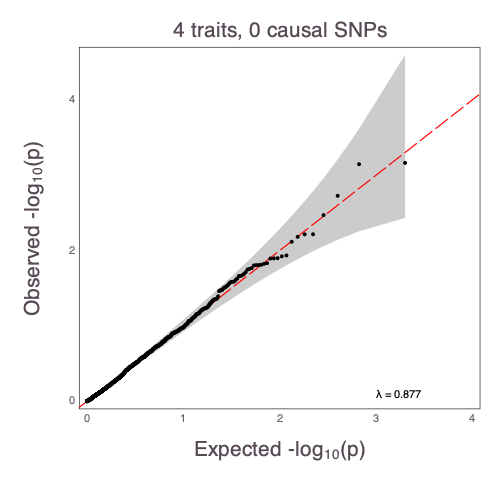

In [102]:
using MendelPlots

# 2 normal, 1 bernoulli, 1 poisson
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))